# Lecture 6 - Data-Driven Algorithms in DynamicalSystems.jl, Parallelism in Julia

## Contents

1. [Data-Driven Algorithms for Chaotic Systems in DynamicalSystems.jl](#data-driven)
2. [CPUs, Cores, and Threads](#cpus)
3. [Parallelism in Julia](#parallelism)
4. [Further Reading](#further-reading)

## 1. Data-Driven Algorithms for Chaotic Systems in DynamicalSystems.jl <a class="anchor" id="data-driven"></a>

In [ ]:
using DynamicalSystems, CairoMakie

Last week we saw how to simulate dynamical systems using DynamicalSystems.jl, and also how to calculate various properties of those systems, such as Lyapunov exponents.

DynamicalSystems.jl also includes algorithms for exploring the properties of chaotic systems purely from data, e.g. from observations.

### 1.1. Delay Coordinate Embedding

You briefly encountered delay coordinate embedding (also know as phase space reconstruction) in the first part of the lecture. Let's explore some simple examples using DynamicalSystems.jl.

In [7]:
# Generate synthetic data
ds = Systems.lorenz()
data = trajectory(ds, 100.0, Ttr = 100.0, Δt = 0.05)

3-dimensional Dataset{Float64} with 2001 points
  5.22753     9.14907   12.8547
  7.5955     13.1661    14.6033
 10.7286     17.4786    19.4383
 13.915      19.2476    27.9442
 15.3066     14.9175    36.6727
 13.3928      6.57322   39.4729
  9.28373     0.533337  36.3105
  5.27928    -1.63932   31.5333
  2.47943    -1.85029   27.2786
  0.82973    -1.58822   23.7464
 -0.0807116  -1.42944   20.7593
 -0.621993   -1.52081   18.1937
 -1.04601    -1.89759   15.9897
  ⋮                     
 11.3352      5.94528   35.8609
  8.37725     2.39696   33.2346
  5.68457     1.07779   29.6108
  3.83742     1.03876   26.1311
  2.82995     1.52575   23.06
  2.46419     2.24781   20.4089
  2.57265     3.19943   18.177
  3.08447     4.51439   16.4133
  4.02598     6.3976    15.2661
  5.49879     9.06259   15.0777
  7.61957    12.5364    16.5184
 10.3395     16.1167    20.5527

For the sake of argument, suppose we could only measure one variable of this system, that is, we have a one-dimensional time series of observations.

In [8]:
timeseries_1d = data[:, 1]

2001-element Vector{Float64}:
  5.22752715027963
  7.595497428482087
 10.728606644081067
 13.914952951117561
 15.306649671355716
 13.392838403526582
  9.283731400582576
  5.279280624511662
  2.479427893722335
  0.8297302666594596
 -0.08071161603523067
 -0.6219929009628147
 -1.046005617493734
  ⋮
 11.335247078768743
  8.377254096616172
  5.6845736696598825
  3.837420788019297
  2.829952796009905
  2.464193392514886
  2.572654397077902
  3.084467333017007
  4.0259829273955985
  5.498786745791098
  7.619568084111802
 10.339516315269304

Now let's attempt to reconstruct the phase space of this one-dimensional time series using various time delays.

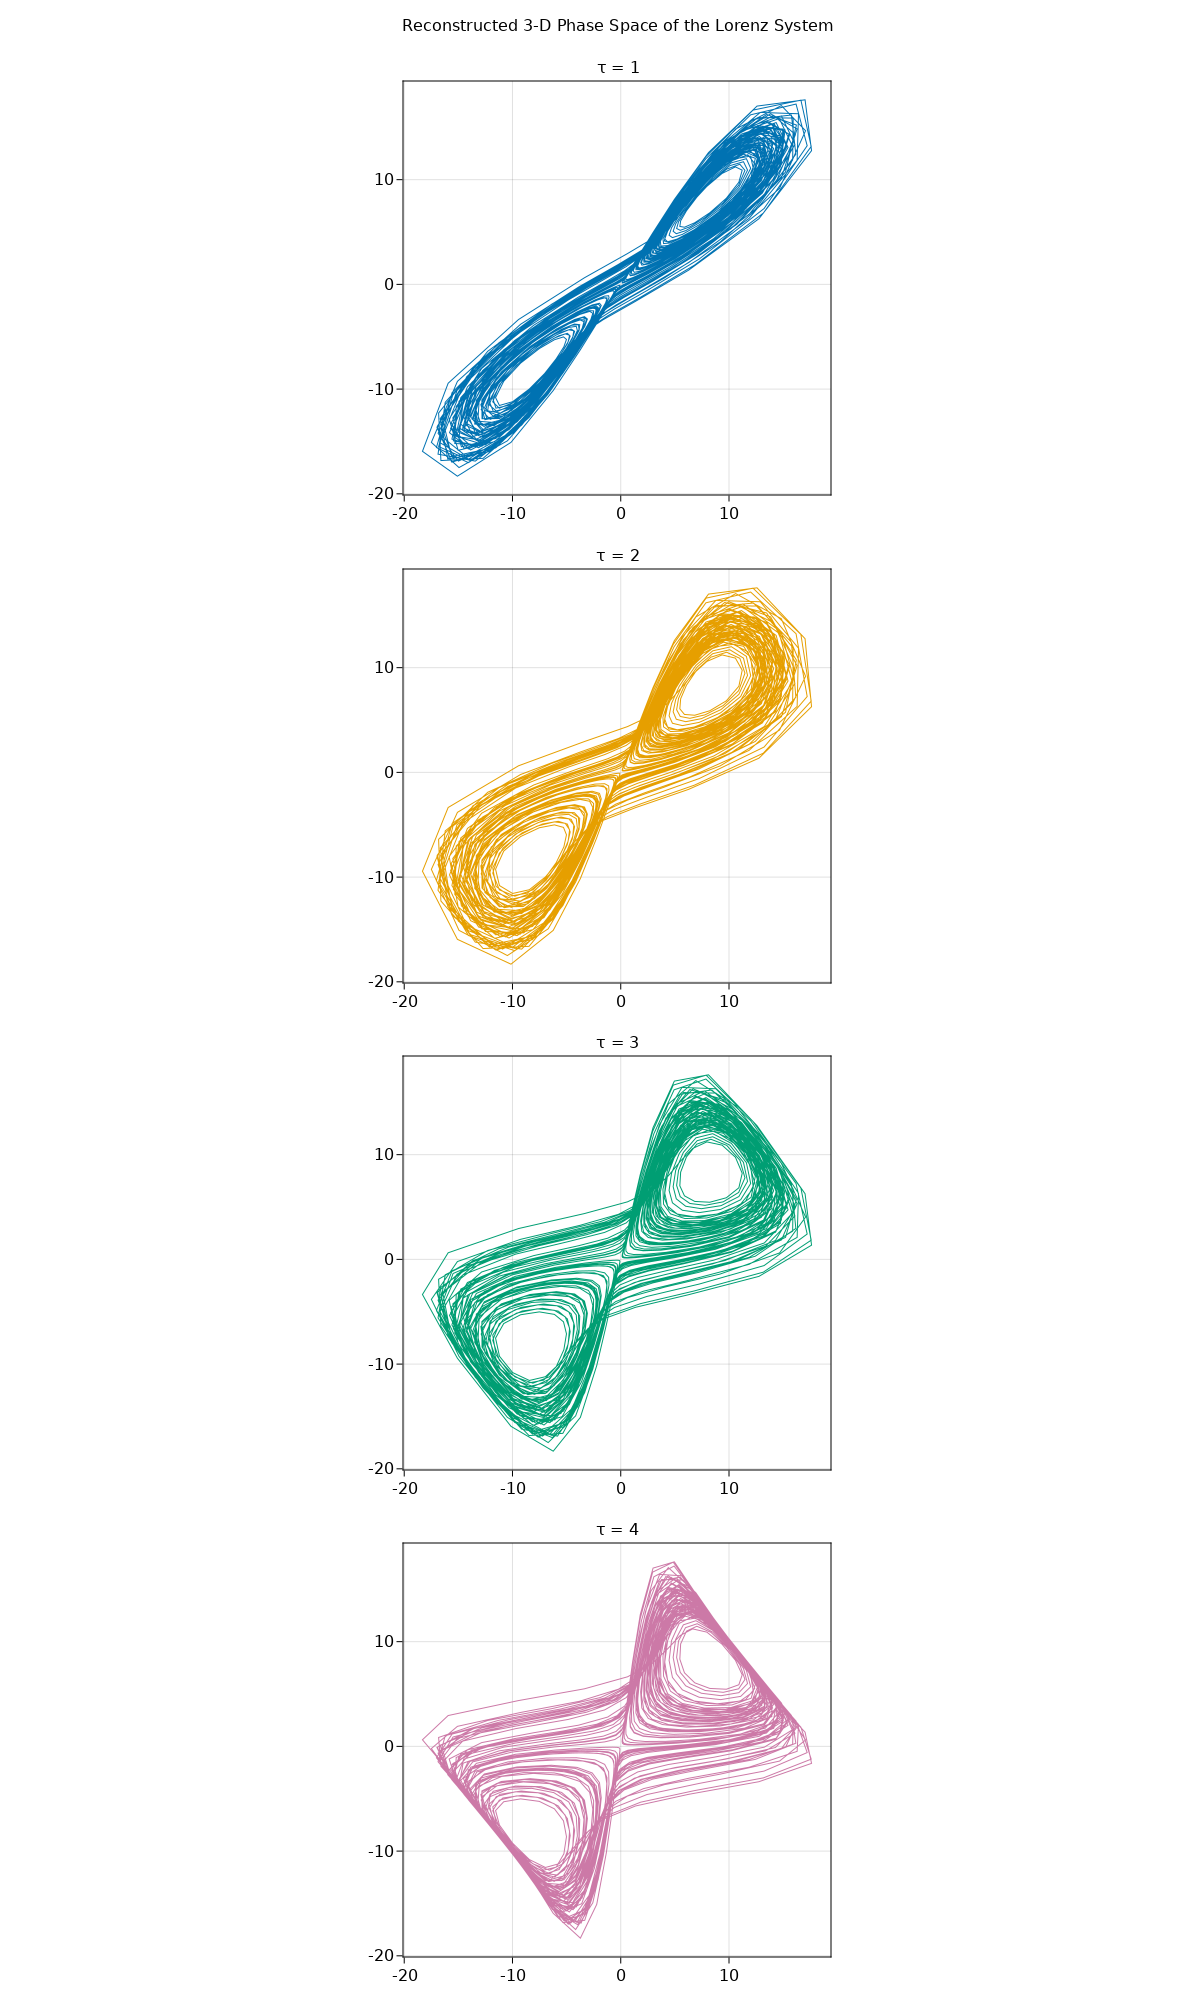

In [9]:
fig = Figure(resolution = (1200, 2000))

for (i, τ) in enumerate(1:1:4)
    data_embedded = embed(timeseries_1d, 3, τ)
    ax = Axis(fig[i, 1]; title = "τ = $τ")
    lines!(ax, data_embedded[:, 1], data_embedded[:, 2], color = Cycled(i), linewidth=1.0)
end

Label(fig[0, :], "Reconstructed 3-D Phase Space of the Lorenz System")
fig

How does this compare to the original, true data?

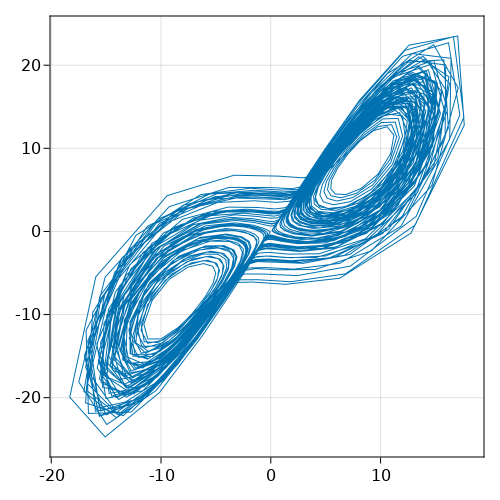

In [10]:
fig = Figure(resolution = (500, 500))
ax = Axis(fig[1, 1])
lines!(ax, data[:, 1], data[:, 2], linewidth=1.0)
fig

Visually, a good value for the delay $τ$ seems to be around 2.

### 1.2. Lypaunov Exponents

The Lyapunov exponent measures the exponential divergence of infinitesimally close trajectories,

$$|\delta (t)| \approx e^{\lambda t}|\delta (0)|.$$

Taking the log of both sides and rearranging,

$$\ln|\delta (t)| - \ln |\delta (0)| \approx \lambda \times t.$$

Given some dataset, we can average over trajectories which are initially close together to obtain an estimate for $\lambda$. To do this, we define the following algorithm:

1. Define neighbourhoods within the data consisting of trajectories which are initially close together (e.g. using k-nearest neighbours).


2. Given those neighbourhoods, define $E(t)$ as the average of $\ln|\delta (t)|$ over all neighbourhoods. Therefore,

$$E(t) - E(0) \approx \lambda \times t.$$

3. Discretise time, $t = k \times Δt$, to obtain,

$$E(k) - E(0) \approx \lambda \times k \times Δt,$$

where $Δt$ is the (known) time interval of the dataset.

4. Finally, given trajectories of a chaotic system, we can estimate the Lyapunov exponent by plotting $E(k) - E(0)$ versus $k \times Δt$ and taking the slope.

`DynamicalSystems.jl` makes this easy by providing the methods `lyapunov_from_data` and `linear_region`.

In [11]:
# Generate synthetic data
ds = Systems.lorenz()
Δt = 0.05
data = trajectory(ds, 10000.0; Δt, Ttr = 100.0)[:, 1];  # Suppose we can only measure the first coordinate

In [ ]:
# embedding with dim 3, time delay τ 
t, t - τ, t - 2τ  

In [ ]:
# embedding with dim 4, time delay τ 
t, t - τ, t - 2τ, t - 3τ

┌ Warning: Found linear region spans less than a 3rd of the available x-axis and might imply inaccurate slope or insufficient data. Recommended: plot `x` vs `y`.
└ @ ChaosTools /home/alistair/.julia/packages/ChaosTools/PHPDF/src/dimensions/linear_regions.jl:143
┌ Warning: Found linear region spans less than a 3rd of the available x-axis and might imply inaccurate slope or insufficient data. Recommended: plot `x` vs `y`.
└ @ ChaosTools /home/alistair/.julia/packages/ChaosTools/PHPDF/src/dimensions/linear_regions.jl:143
┌ Warning: Found linear region spans less than a 3rd of the available x-axis and might imply inaccurate slope or insufficient data. Recommended: plot `x` vs `y`.
└ @ ChaosTools /home/alistair/.julia/packages/ChaosTools/PHPDF/src/dimensions/linear_regions.jl:143


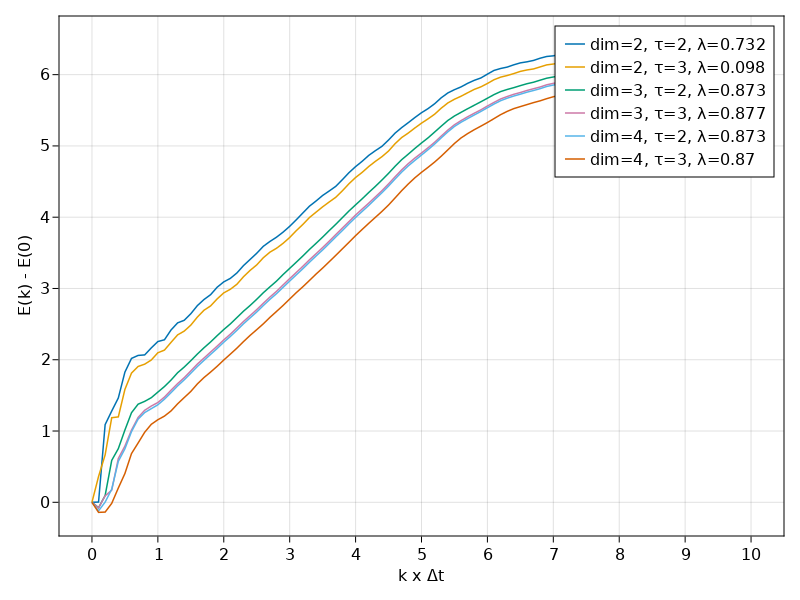

In [12]:
ks = 0:2:200  # Integer timesteps

fig = Figure(figsize=(500,500))
ax = Axis(fig[1, 1], xlims = (0,10), xticks = 0:1:10, xlabel="k x Δt", ylabel="E(k) - E(0)")

for dim in [2, 3, 4], τ in [2, 3]  # Try different embedding dimensions and time delays
    data_embedded = embed(data, dim, τ)
    E = lyapunov_from_data(data_embedded, ks)  # Returns [E(k) for k ∈ ks]
    λ = linear_region(ks .* Δt, E)[2]          # Returns the slope of the linear region, i.e. the Lyapunov exponent
    lines!(ax, ks .* Δt, E .- E[1], label = "dim=$(dim), τ=$(τ), λ=$(round(λ, digits = 3))")
end

axislegend(ax)
fig

How do these estimates compare to the true Lyapunov exponent?

In [16]:
lyapunov(ds, 10000, Ttr = 100)

0.905575457813565

That's surprisingly good, especially when you consider that we started with a one-dimensional time series.

### 1.3. Other Data-Driven Algorithms in `DynamicalSystems.jl`
- Automatically find the optimal embedding dimension and delay given a time series (these algorithms are divided into so-called [traditional](https://juliadynamics.github.io/DynamicalSystems.jl/latest/embedding/traditional/) and [unified](https://juliadynamics.github.io/DynamicalSystems.jl/latest/embedding/unified/) approaches).
- [Fractal dimensions](https://juliadynamics.github.io/DynamicalSystems.jl/latest/chaos/fractaldim/#Generalized-dimension).

## 2. CPUs, Cores, and Threads <a class="anchor" id="cpus"></a>

Early CPUs consisted of a single computational unit (core), and therefore could only execute one process (or one set of instructions) at any one time.

In practice, this means that a single-core CPU will constantly switch between individual processes, or threads of execution (this is called *context switching*). This procedure happens so quickly, however, that the user has the illusion that everything is happening simultaneously.

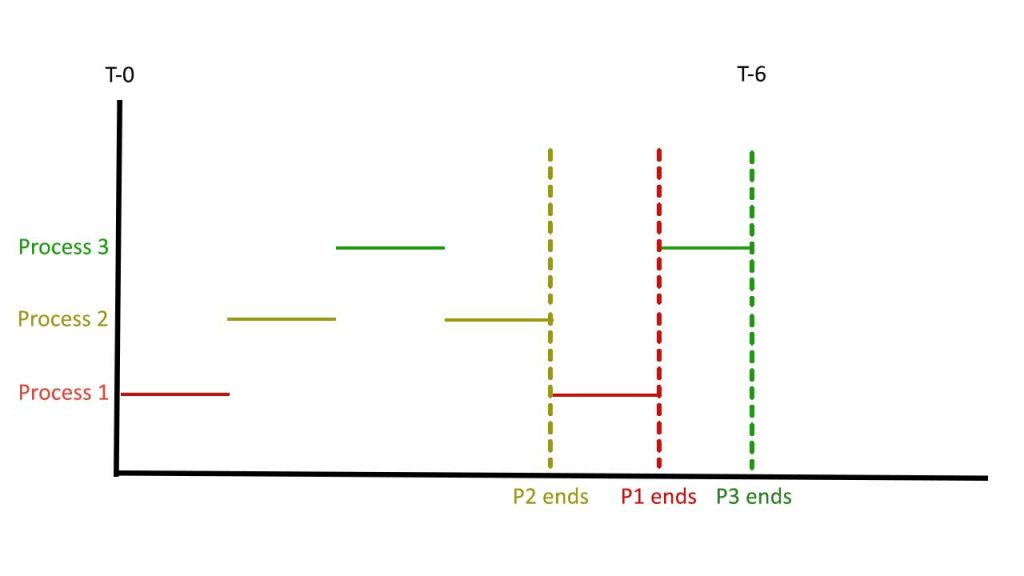
Source: [temok.com](https://www.temok.com/blog/cores-vs-threads/)

Modern CPUs are usually multi-core, meaning a single CPU has multiple computational units (cores). This means that multiple threads can now actually be executed in parallel (it's no longer simply a clever illusion).

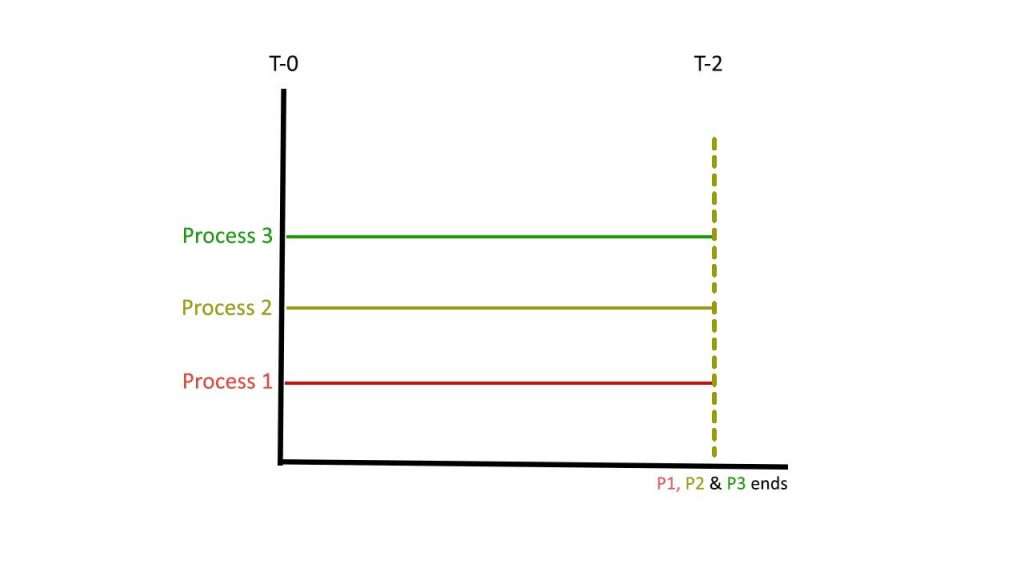
Source: [temok.com](https://www.temok.com/blog/cores-vs-threads/)

How many cores does the CPU on your computer have? 

1. On Linux, do `lscpu`.
2. On macOS, do `sysctl hw.physicalcpu hw.logicalcpu`.
3. On Windows, do `WMIC CPU Get NumberOfCores,NumberOfLogicalProcessors` (or go to the Task Manager and select the tab Performance).

In [17]:
; lscpu

Architecture:                    x86_64
CPU op-mode(s):                  32-bit, 64-bit
Address sizes:                   39 bits physical, 48 bits virtual
Byte Order:                      Little Endian
CPU(s):                          8
On-line CPU(s) list:             0-7
Vendor ID:                       GenuineIntel
Model name:                      11th Gen Intel(R) Core(TM) i7-1185G7 @ 3.00GHz
CPU family:                      6
Model:                           140
Thread(s) per core:              2
Core(s) per socket:              4
Socket(s):                       1
Stepping:                        1
CPU(s) scaling MHz:              50%
CPU max MHz:                     4800.0000
CPU min MHz:                     400.0000
BogoMIPS:                        3609.60
Flags:                           fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush dts acpi mmx fxsr sse sse2 ss ht tm pbe syscall nx pdpe1gb rdtscp lm constant_tsc art arch_perfmon pebs bts rep_

According to this, I have 8 CPUs, but that's not quite correct. Let's look at the output more closely.

- **Socket(s)**: This is the number of physical CPUs in my computer. Like most laptops and desktop computers, I have one.
- **Core(s) per socket**: This is the number of physical cores my CPU has. My CPU has 4 (it is a quad-core processor).
- **Thread(s) per core**: Each CPU core on my computer can support two "simultaneous" threads of execution. This is an example of [simultaneous multithreading](https://en.wikipedia.org/wiki/Simultaneous_multithreading) (SMT), which allows more than one thread to run simultaneously on a single physical core. Of course, the two processes, running on a single core, are not actually simultaneous. Essentially, the CPU exploits idle time in one thread to execute tasks on the other thread, giving the illusion of genuine parallel execution (along with some of the benefit). Hence each *physical core* on my computer appears to the operating system as two *logical cores* on which tasks can be completed.

Therefore the total number of threads (logical cores) available for execution on my computer is given by,

$$\mathrm{Sockets} \times \mathrm{Cores\,per\,socket} \times \mathrm{Threads\,per\,core} = 8 \,\mathrm{Threads\,(logical\,cores)}.$$

## 3. Parallelism in Julia <a class="anchor" id="parallelism"></a>

Given multiple cores (physical and logical) available for parallel execution, it would be great if we could split our computationally intensive Julia programs up into subtasks that could be efficiently executed in parallel. As you've probably guessed, this is extremely straightforward in Julia.

### 3.1. Types of Parallelism in Julia
Julia supports four different types of parallel programming:

1. **Asynchronous (Concurrent) Programming**: tasks can be run while the thread waits for other tasks (e.g. I/O) to finish. Not technically parallel, but conceptually similar to the other types of parallel programming in its implementation.
2. **Multi-Threading**: individual tasks are distributed to multiple threads for parallel execution. This is the easiest to implement on a typical computer, and will be the focus of today's lecture.
3. **Distributed Computing**: tasks are distributed to multiple CPUs (or multiple computers), each with its own instance of Julia running, for parallel execution. The supercomputing clusters on which climate models are run are an example of massive distributed computing. (On Monday this week, it was [announced](https://top500.org/news/ornls-frontier-first-to-break-the-exaflop-ceiling/) that the Frontier supercomputer at Oak Ridge National Laboratory in the US, with 8,730,112 total cores, became the first system to break the Exaflop barrier - $10^{18}$ floating-point operations per second. It cost US$600 million to build.)
4. **GPU Programming**: originally intended for computer graphics, GPUs are designed for massively parallel execution, with thousands of small, individual cores. GPUs are particularly well-suited to operations like matrix multiplication, hence their widespread adoption in deep learning applications.

### 3.2. Multi-Threading in Julia
Multi-threading is parallelism you can do on a single (multi-core) CPU. By default, Julia starts up with a single thread of execution.

In [18]:
Threads.nthreads()

1

To specify the number of threads when starting Julia from the command line, either use the `--threads` command line argument,

`julia --threads 8`,

or set the environment variable `JULIA_NUM_THREADS`,

`export JULIA_NUM_THREADS=8`.

To use multiple threads in a Jupyter notebook, you can install a custom kernel spec:

```julia
using IJulia
IJulia.installkernel("Julia (8 Threads)", env=Dict("JULIA_NUM_THREADS" => "8"))
```

Let's switch the kernel and see how many threads we've got now.

In [1]:
Threads.nthreads()

8

Excellent, now we can write Julia code which will run in parallel across 8 threads.

The most common and straightforward way of writing multi-threaded code in Julia is to affix the `Threads.@threads` macro in front of a `for` loop.

In [2]:
for i = 1:5
    println("Hello from thread ", Threads.threadid())
end

Hello from thread 1
Hello from thread 1
Hello from thread 1
Hello from thread 1
Hello from thread 1


In [3]:
Threads.@threads for i = 1:10
    println("Hello from thread ", Threads.threadid())
end

Hello from thread 1
Hello from thread 1
Hello from thread 8
Hello from thread 3
Hello from thread 7
Hello from thread 5
Hello from thread 6
Hello from thread 4
Hello from thread 2
Hello from thread 2


That's how easy it is implement multi-threading in your Julia programs!

As a slightly more interesting example, let's say we want to flip a coin $N$ times and return the proportion of heads.

In [4]:
function count_heads(N)
    heads = zeros(Bool, N)  # Store the result of each coin toss

    for i in eachindex(heads)
        if rand() > 0.5
            heads[i] = true
        end
    end

    return sum(heads) / N
end

count_heads (generic function with 1 method)

In [5]:
N = 10^5
count_heads(N)

0.49823

In [6]:
using BenchmarkTools
@btime count_heads(N);

  703.831 μs (3 allocations: 97.75 KiB)


In [7]:
function count_heads_threaded(N)
    heads = zeros(Bool, N)

    Threads.@threads for i in eachindex(heads)
        if rand() > 0.5
            heads[i] = true
        end
    end

    return sum(heads) / N
end

count_heads_threaded (generic function with 1 method)

In [8]:
count_heads_threaded(N)

0.49853

In [9]:
@btime count_heads_threaded(N);

  147.523 μs (44 allocations: 101.61 KiB)


First notice that we get a slight increase in memory allocations in the threaded version. This is due to the additional accounting done by the `Threads.@threads` macro to create tasks and allocate them to different threads.

Despite the (very modest) increase in allocations, we still see a 5x speedup of the multi-threaded code compared to the single-threaded version!

### 3.3. Race Conditions
Not all code can be so easily and productively parallelised. In particular, you need to be careful of [race conditions](https://en.wikipedia.org/wiki/Race_condition#In_software) when writing multi-threaded code:

>A race condition arises in software when a computer program, to operate properly, depends on the sequence or timing of the program's processes or threads.

To illustrate race conditions, consider an alternative formulation of our coin-tossing procedure in which we simply increment a counter.

In [10]:
function count_heads(N)
    heads = 0  # counter

    for i in 1:N
        if rand() > 0.5
            heads += 1
        end
    end

    return heads / N
end

count_heads (generic function with 1 method)

In [17]:
count_heads(N)

0.50126

In [18]:
function count_heads_threaded(N)
    heads = 0  # counter

    Threads.@threads for i in 1:N
        if rand() > 0.5
            heads += 1
        end
    end

    return heads / N
end

count_heads_threaded (generic function with 1 method)

In [43]:
count_heads_threaded(N)

0.17805

The function returned with any errors, but the answer is definitely wrong! What's going on here?

To understand, consider the sequence of events in the case where there are two threads and everything works properly.

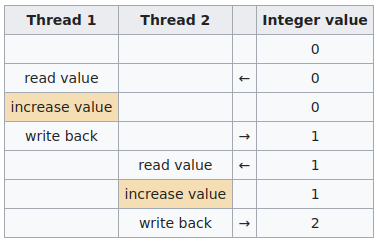

After incrementing the counter twice, its value is 2, as expected.

Now consider what happens if the threads overlap, and the precise sequence of events changes.

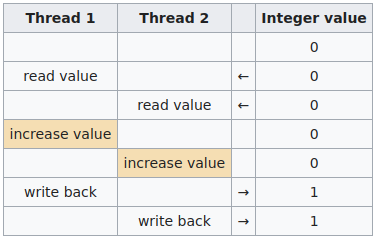

Now we've incremented the counter twice but its value remains at 1, which is obviously wrong.

Like our coin tossing example, the program completes without any errors but the result of the calculation is wrong due to the race condition.

A famous example of a bug due to race conditions is the [Therac-25](https://en.wikipedia.org/wiki/Therac-25) machine for radiation therapy.

### 3.4. Avoiding Race Conditions

A number of strategies are possible to avoid race conditions in multi-threaded code. 

The best strategy of all is to **design your code to avoid race conditions in the first place.**

If that simply isn't possible, Julia supports accessing and modifying values *atomically*, that is, in a thread-safe way.

There are a number of ways to make your code atomic in Julia. The most common method is to use a *lock*. A lock is essentially an object which can only be in the possession of one thread at a time.

Given a lock `lk`, such as `ReeantrankLock` or `Threads.SpinLock`, atomic operations may be performed with the syntax,

```julia
lock(lk) do
    <atomic work>
end
```

where the lock is automatically released again at the end of the do block.

In [44]:
function count_heads_lock(N)
    heads = 0
    lk = Threads.SpinLock()

    Threads.@threads for i in 1:N
        if rand() > 0.5
            lock(lk) do     # Wait for the lock if it is not available
                heads += 1  # Do atomic work inside the do block, while in possession of the lock
            end
        end
    end

    return heads / N
end

count_heads_lock (generic function with 1 method)

In [53]:
count_heads_lock(N)

0.49999

In [54]:
@btime count_heads_lock(N)

  6.597 ms (49137 allocations: 771.00 KiB)


0.4985

In this (trivial) example, the lock seriously degrades the performance of our routine, emphasising our preference for designing our code to be thread-safe without resorting to atomic operations. 

However, in normal programs, where the atomic operation makes up just a small proportion of the total computation in each iteration, the impact on performance may not be so drastic.

## 4. Further Reading <a class="anchor" id="further-reading"></a>
1. [DynamicalSystems.jl](https://juliadynamics.github.io/DynamicalSystems.jl/latest/) documentation.
2. Julia [Parallel Computing](https://docs.julialang.org/en/v1/manual/parallel-computing/).